In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

%matplotlib inline


So, yes, again, I'm trying to show a play-by-play analysis of the Israeli GTFS for SIRI archiving purposes we have at [hasadna/open-bus](https://github.com/hasadna/open-bus).

I'm drifting a bit from the main purpose of these analyses, because I have to do some prep work on graphs and geo visualizations. I In order to do so I with mapping stuff with different colors, and also do some basic work with networkx graphs. This is all preliminary work, and I'll do more meaniningful stuff in the next posts. 

The agenda this time is: (again, you can skip to item 3 if you're just interested in the stats, or if you already read the previous post):
1. [Get up-to-date GTFS files from the MOT FTP server](#Get-the-data)
2. [Extract the needed info from them into pandas tidy DataFrames](#Tidy-it-up)
3. [Interactive bokeh maps](#Interactive-bokeh-maps)
4. [Experimenting with some graph magic](#Experimenting-with-some-graph-magic)
5. [One the next episodes](#On-the-next-episodes) Yep, not all is covered in this notebook

On the pedagogical side, 

## Get the data
We get the data straight from MOT's ftp. Just so I don't repeat the last post, this went out to a separate module.

In [123]:
from gtfs_utils import *

conn = ftp_connect()
ftp_dir = get_ftp_dir(conn)
UPTODATE = 90 #days
our_uptodateness = get_uptodateness(ftp_dir)

if our_uptodateness > UPTODATE:
    get_ftp_file(conn)
    get_ftp_file(conn, file_name = 'Tariff.zip', local_zip_path = 'data/sample/tariff.zip' )

conn.quit()

'221 Goodbye.'

We load MOT's tarrif.txt file, which will give us zone names and other local info.
Found out it's the file is even more fd-up than I realized, so I add the southern zones manualy

In [124]:
tariff_df = extract_tariff_df(local_zip_path = 'data/sample/tariff.zip')
south = [
    {
        'zone_name': 'מצפה רמון',
        'zone_id': '903'
    },
    {
        'zone_name': 'ערבה',
        'zone_id': '902'
    },
    {
        'zone_name': 'אילת',
        'zone_id': '901'
    },]
south = pd.DataFrame(south)
tariff_df = tariff_df.append(south)
tariff_df.tail()

,Daily,FromDate,Monthly,ShareCode,ToDate,Weekly,zone_id,zone_name
72,13.5,01/04/2016 00:00:00,149.0,753.0,01/01/2200 00:00:00,57.5,234,השומרון
73,13.5,01/04/2016 00:00:00,149.0,754.0,01/01/2200 00:00:00,57.5,135,גוש שילה ובקעה
0,NaN,NaN,NaN,NaN,NaN,NaN,903,מצפה רמון
1,NaN,NaN,NaN,NaN,NaN,NaN,902,ערבה
2,NaN,NaN,NaN,NaN,NaN,NaN,901,אילת


## Tidy it up
Again I'm using [partridge](https://github.com/remix/partridge/tree/master/partridge) for filtering on dates, and then some tidying up and transformations.

In [125]:
LOCAL_ZIP_PATH = 'data/sample/gtfs.zip' 

import partridge as ptg

service_ids_by_date = ptg.read_service_ids_by_date(LOCAL_ZIP_PATH)
service_ids = service_ids_by_date[datetime.date(2017, 12, 21)]

feed = ptg.feed(LOCAL_ZIP_PATH, view={
    'trips.txt': {
        'service_id': service_ids,
    },
})

In [126]:
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time', 'departure_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df

s = feed.stops
r = feed.routes
t = (feed.trips
     .assign(route_id=lambda x: pd.Categorical(x['route_id'])))

f = (feed.stop_times[['trip_id', 'departure_time', 'arrival_time', 'stop_id', 'stop_sequence']]
     .assign(date = datetime.date(2017, 12, 21))
     .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'zone_id']], on='stop_id')
     # Much faster joins and slices with Categorical dtypes
     .merge(tariff_df[['zone_id', 'zone_name']], on='zone_id')
     .assign(zone_id=lambda x: pd.Categorical(x['zone_id']))
     .assign(zone_name=lambda x: pd.Categorical(x['zone_name']))
     .merge(t[['trip_id', 'route_id', 'direction_id']], on='trip_id')
     .merge(r[['route_id', 'route_short_name', 'route_long_name']], on='route_id')
     .assign(route_id=lambda x: pd.Categorical(x['route_id']))
     .pipe(to_timedelta)
    )
f.head()

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,direction_id,route_short_name,route_long_name
0,28917380_191217,08:57:00,08:57:00,37312,1,2017-12-21,באר שבע מרכז,31.242886,34.798546,410,באר שבע,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
1,28917380_191217,09:04:00,09:04:00,37314,2,2017-12-21,באר שבע-צפון,31.262089,34.809287,410,באר שבע,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
2,28917380_191217,09:13:00,09:13:00,37308,3,2017-12-21,להבים רהט,31.369907,34.798040,421,רהט להבים,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
3,28917380_191217,09:29:00,09:29:00,37316,4,2017-12-21,קרית גת,31.603526,34.777955,802,קריית גת,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
4,28917380_191217,09:54:00,09:54:00,37336,5,2017-12-21,רמלה,31.928809,34.877304,210,גוש דן,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו


## Interactive bokeh maps
I'm starting by repeating the same map from last time.

In [127]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [128]:
from bokeh.plotting import figure
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.palettes import inferno, magma

# web mercator coordinates (got them here https://epsg.io/map)
Center_Israel = x_range, y_range = ((3852120,3852120+10e4), (3729820,3729820+10e4/1.3))

plot_width  = int(540)
plot_height = int(plot_width//1.3)

def base_plot(tools='pan,wheel_zoom,box_zoom,reset', active_drag='pan', 
              active_scroll='wheel_zoom', toolbar_location='left',
              plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, active_drag=active_drag, active_scroll=active_scroll,
               toolbar_location=toolbar_location,
                plot_width=plot_width, plot_height=plot_height,
                x_range=x_range, y_range=y_range, outline_line_color=None,
                min_border=0, min_border_left=0, min_border_right=0,
                min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

def wgs84_to_web_mercator(df, lon="stop_lon", lat="stop_lat"):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

stops = (s[['stop_lon', 'stop_lat', 'stop_id', 'zone_id']].set_index('stop_id')
         .pipe(wgs84_to_web_mercator)
         .assign(counts = f.stop_id.value_counts())
         .sort_values(by='counts', ascending=False))

pal = inferno(256)
c256 = 255 - pd.cut(stops.counts.fillna(0), 256).cat.codes
colors = [pal[c] for _, c in c256.iteritems()]

options = dict(line_color=None, fill_color=colors, size=5)

p = base_plot()
p.add_tile(CARTODBPOSITRON)

p.circle(x=stops['x'], y=stops['y'], **options)
show(p)

### Zone map
And here I give a categorical map of `zone_id`s.

>Due to the limits of perception, especially simultaneous contrast, the maximum number of categories that can be displayed is about 12 (practically speaking, probably fewer). [Source](https://earthobservatory.nasa.gov/blogs/elegantfigures/2013/08/12/subtleties-of-color-part-3-of-6/)

We have about 40 zones, so we have to do something about this...

> If you need to display double-digit categories, it’s best to group similar classes together. [Same source](https://earthobservatory.nasa.gov/blogs/elegantfigures/2013/08/12/subtleties-of-color-part-3-of-6/)

Well, we won't do this now, but rather try to cycle the colors, and try to make the neighboring colors different this way. This should work since we shouldn't have spatial overlap between zones, and if we have  a little bit of it should stay within the neighboring zones.

TODO: add a legend or text layer

In [143]:
from bokeh.palettes import Category20, viridis
top_zones = f.groupby('zone_id').size().sort_values(ascending=False)#.head(20)

stops_zone = (stops#[(stops.zone_id.isin(top_zones.index))]
              .merge(tariff_df[['zone_id', 'zone_name']], on='zone_id')
              .assign(zone_id=lambda x: pd.Categorical(x['zone_id']))
              .assign(zone_name=lambda x: pd.Categorical(x['zone_name'])))

# we have 39 categories, so we need to chang to viridis, uncomment 
# and run this cell a few times until it looks good in your opinion
# from random import shuffle
# pal = viridis(stops_zone.zone_id.nunique())
# shuffle(pal)
# ---
# other method - double the palette to cycle 
# (we get double colors, so we can't legend, but it's easier to look at i think)
# layering with text of the zone_name will probably work best
pal = Category20[20]
pal *= 3
colors = [pal[c] for _, c in stops_zone.zone_id.cat.codes.iteritems()]

options = dict(line_color=None, fill_color=colors, size=5)

plot_width  = int(540)
plot_height = int(plot_width//1.3)
p = base_plot(plot_width=plot_width, plot_height=plot_height)
p.add_tile(CARTODBPOSITRON)

p.circle(x=stops_zone['x'], y=stops_zone['y'], **options)
show(p)

## Experimenting with some graph magic
I'm using [peartree](https://github.com/kuanb/peartree) to turn a GTFS feed into a directed graph.

In [141]:
import peartree as pt
import os
import pickle

In [131]:
PKL_PATH = 'graph.pkl'
#Creating the graph takes a gazillion time so I pickle it
if not os.path.exists(PKL_PATH):
    # Automatically identify the busiest day and
    # read that in as a Partidge feed
    feed = pt.get_representative_feed(LOCAL_ZIP_PATH)

    # Set a target time period to
    # use to summarize impedance
    start = 7*60*60  # 7:00 AM
    end = 10*60*60  # 10:00 AM

    # Converts feed subset into a directed
    # network multigraph
    G = pt.load_feed_as_graph(feed, start, end)
    with open(PKL_PATH, 'wb') as pkl_file:
        pickle.dump(G, pkl_file)
else:
    with open(PKL_PATH, 'rb') as pkl_file:
        G = pickle.load(pkl_file)

### Pseudo satellite image

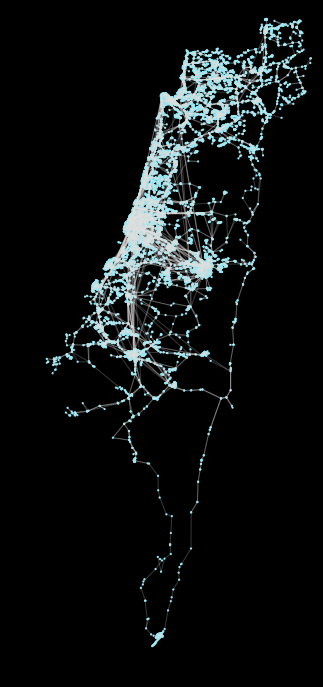

In [132]:
fig, ax = pt.generate_plot(G)
default_size = fig.get_size_inches()

fig.set_size_inches(default_size[0]*1, default_size[1]*1)

This is very pretty indeed, but In order to visualize some measures with detail, I'll zoom into the TLV (גוש דן) area.`

I prepare a filter for Tel-Aviv routes (routes that have all their stations in TLV), in order to filter the partridge feed. We can only filter by the fields that are present in `trips.txt`, since it is the root in our config, so we cannot filter by `zone_id`. 

In [133]:
# return True if all zone_names of DF are TLV
def all_tlv(df):
    return (df.zone_name=='גוש דן').all()

tlv_routes = (f[['route_id', 'zone_name']].groupby(['route_id'])
              # check all_tlv on all routes' stations
              .agg(all_tlv)
              # keep only the ones that are actually all TLV
              .pipe(lambda x: x[x.zone_name]))

tlv_routes.shape

(753, 1)

In [134]:
TLV_PKL_PATH = 'tlv_graph.pkl'
#Creating the graph takes a gazillion time so I pickle it
if not os.path.exists(TLV_PKL_PATH):
    # using the same service_ids that we used in the
    # original feed but filtered down to tlv
    feed = ptg.feed(LOCAL_ZIP_PATH, view={
        'trips.txt': {
            'service_id': service_ids,
            'route_id': tlv_routes.index.tolist(),
        },
    })

    # Set a target time period to
    # use to summarize impedance
    start = 7*60*60  # 7:00 AM
    end = 10*60*60  # 10:00 AM

    # Converts feed subset into a directed
    # network multigraph
    GT = pt.load_feed_as_graph(feed, start, end)
    with open(TLV_PKL_PATH, 'wb') as pkl_file:
        pickle.dump(GT, pkl_file)
else:
    with open(TLV_PKL_PATH, 'rb') as pkl_file:
        GT = pickle.load(pkl_file)

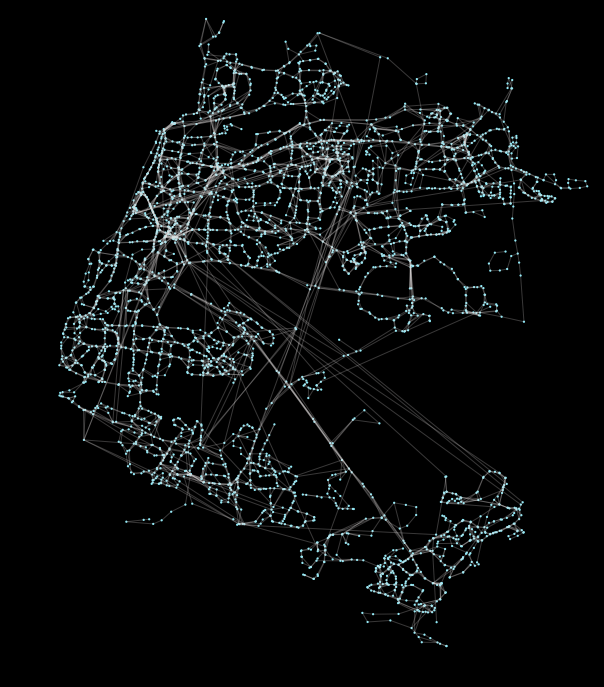

In [135]:
fig, ax = pt.generate_plot(GT)
default_size = fig.get_size_inches()

fig.set_size_inches(default_size[0], default_size[1])

Good. Now we can distinguish the stops and this is also more reasonable to use for statistical measures on the graph.

## Centrality
### Betweenness Centrality
Heavily based on the recipe to visualize betweenness centrality by kuanb [here](http://kuanbutts.com/2017/12/13/betweenness-centrality-peartree/).

In [136]:
import geopandas as gpd
import networkx as nx
import osmnx as ox
from shapely.geometry import Point

In [137]:
BETW_PKL_PATH = 'betw.pkl'
if not os.path.exists(BETW_PKL_PATH):
    nodes = nx.betweenness_centrality(GT)

    nids = []
    vals = []
    for k in nodes.keys():
        nids.append(k)
        vals.append(nodes[k])

    min(vals), np.array(vals).mean(), max(vals)
    # prints (0.0, 0.0057453979174797599, 0.11406771048983973)

    vals_adj = []
    m = max(vals)
    for v in vals:
        if v == 0:
            vals_adj.append(0)
        else:
            r = (v/m)
            vals_adj.append(r * 0.01)
            
    with open(BETW_PKL_PATH, 'wb') as pkl_file:
        pickle.dump((nodes, nids, vals_adj), pkl_file)
else:
    with open(BETW_PKL_PATH, 'rb') as pkl_file:
        nodes, nids, vals_adj = pickle.load(pkl_file)

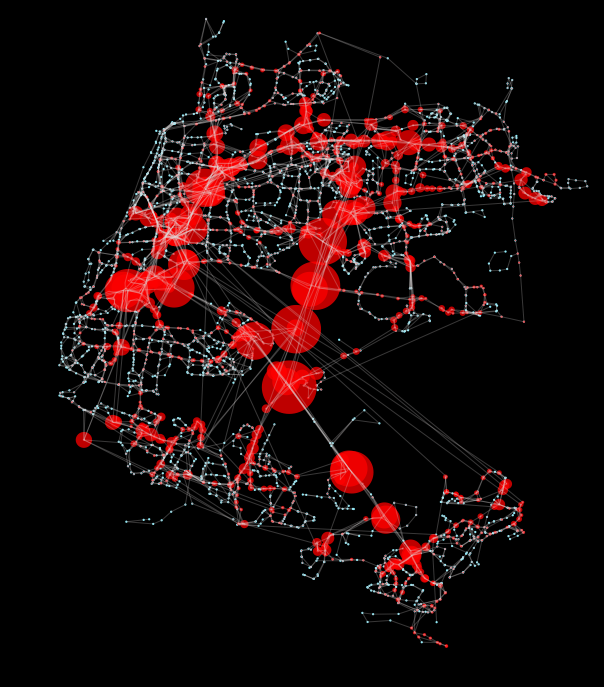

In [138]:
fig, ax = pt.generate_plot(GT)

ps = []
for nid, buff_dist in zip(nids, vals_adj):
    n = GT.node[nid]
    if buff_dist > 0:
        p = Point(n['x'], n['y']).buffer(buff_dist)
        ps.append(p)
    
gpd.GeoSeries(ps).plot(ax=ax, color='r', alpha=0.75)

You can check out the networkx [documentation](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html) on `betweenness_centrality`. 

I tried to think about what this centrality measure gives us here. Every node gets a value according to how many shortest-paths between two other nodes pass through it. The shortest path for us only takes into account the edge weight `length`, which means the centrality measure does not take into account the volume of buses passing through. It's quite interesting and not useless. Right now, as I understand it, the measure is only concerned with "how many other stops is this stop important to?", which somewhat more weight on geographic spread, since stops are pretty much geogrphically evenly distributed, as opposed to number of buses or riders. Other measures can for example ask "how many buses is this stop important to?", or even "how many riders, or certain groups of riders is this stop important to?".


Well, I found some work done on centrality measures in transportation data - I'll try to do something with it in the future. 
- *Cheng YY., Lee R.KW., Lim EP., Zhu F. (2015) Measuring Centralities for Transportation Networks Beyond Structures. In: Kazienko P., Chawla N. (eds) Applications of Social Media and Social Network Analysis. Lecture Notes in Social Networks. Springer, Cham. https://doi.org/10.1007/978-3-319-19003-7_2*

- *Ulrik Brandes, On variants of shortest-path betweenness centrality and their generic computation, Social Networks, Volume 30, Issue 2, 2008, Pages 136-145, ISSN 0378-8733, https://doi.org/10.1016/j.socnet.2007.11.001.*

### Load centrality
Networkx comes out-of-the-box with `load_centrality` ([docs](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.load_centrality.html#networkx.algorithms.centrality.load_centrality)), lets try it:

In [139]:
LOAD_PKL_PATH = 'load.pkl'
if not os.path.exists(LOAD_PKL_PATH):
    nodes = nx.load_centrality(GT, weight='length')

    nids = []
    vals = []
    for k in nodes.keys():
        nids.append(k)
        vals.append(nodes[k])

    min(vals), np.array(vals).mean(), max(vals)
    # prints (0.0, 0.0057453979174797599, 0.11406771048983973)

    vals_adj = []
    m = max(vals)
    for v in vals:
        if v == 0:
            vals_adj.append(0)
        else:
            r = (v/m)
            vals_adj.append(r * 0.01)
            
    with open(LOAD_PKL_PATH, 'wb') as pkl_file:
        pickle.dump((nodes, nids, vals_adj), pkl_file)
else:
    with open(LOAD_PKL_PATH, 'rb') as pkl_file:
        nodes, nids, vals_adj = pickle.load(pkl_file)

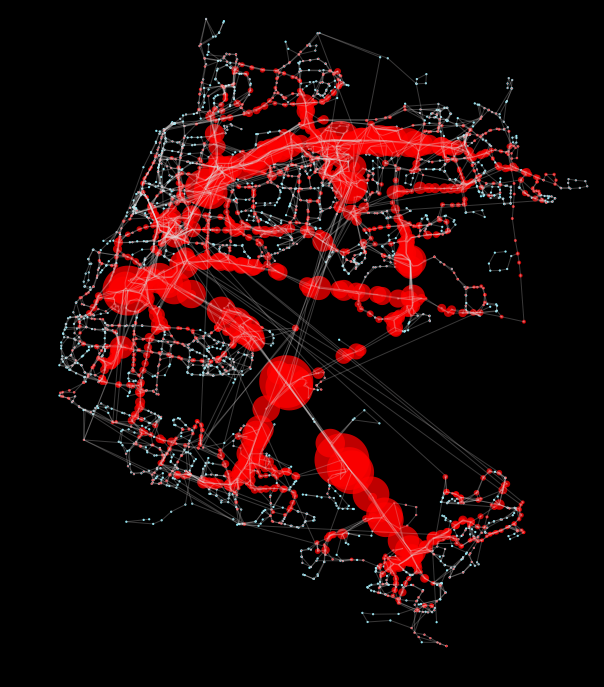

In [140]:
fig, ax = pt.generate_plot(GT)

ps = []
for nid, buff_dist in zip(nids, vals_adj):
    n = GT.node[nid]
    if buff_dist > 0:
        p = Point(n['x'], n['y']).buffer(buff_dist)
        ps.append(p)
    
gpd.GeoSeries(ps).plot(ax=ax, color='r', alpha=0.75)

This is a quite different than the load centrality. The docs state it's the fraction of total shotest-paths that pass through it. Didn't get into fully understanding it yet...

## On the next episodes
OK, enough for now, on the next posts: 

* TODO: Turn it all to day-of-week means
* TODO: some dynamic bokeh web applet to use this as a tool
* TODO: More geo visualizations (Datashader :O)
* TODO: More centrality measures
* TODO: Looped routes analysis